In [2]:
!pip install scrapy
!pip install requests
!pip install selenium
import numpy as np
import pandas as pd
import scrapy
import matplotlib.pyplot as plt
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
import pmdarima as pm
!pip install plotly
import plotly.graph_objs as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
# !pip install -U keras-tuner
# import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
!pip install arch
from arch import arch_model


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 4.5 MB/s eta 0:00:00


## PE Ratio

In [3]:
# Fetch the data
url = 'https://www.macrotrends.net/stocks/charts/AAPL/apple/pe-ratio'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

response = requests.get(url, headers=headers)
response.raise_for_status()
data = pd.read_html(response.text, skiprows=1)
df = pd.DataFrame(data[0])
df = pd.concat([df.columns.to_frame().T, df], ignore_index=True)
df.columns = range(len(df.columns))
df = df[1:]
df = df.rename(columns={0: 'Date', 1: 'Price', 2: 'EPS', 3: 'PE ratio'})
df.set_index('Date', inplace=True)
df = df.iloc[1:, :]
df['PE ratio'] = df['PE ratio'].astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index().reset_index()
l = len(df['EPS'])
df.head()

,Date,Price,EPS,PE ratio
0,2009-12-31,6.36,$0.31,20.57
1,2010-03-31,7.1,$0.36,19.53
2,2010-06-30,7.59,$0.44,17.24
3,2010-09-30,8.57,$0.54,15.83
4,2010-12-31,9.74,$0.64,15.23


                                Date   PE ratio
count                             58  58.000000
mean   2017-02-13 11:35:10.344827648  17.740517
min              2009-12-31 00:00:00   8.550000
25%              2013-07-23 00:00:00  12.375000
50%              2017-02-14 00:00:00  15.510000
75%              2020-09-07 00:00:00  22.377500
max              2024-03-31 00:00:00  35.220000
std                              NaN   7.102041


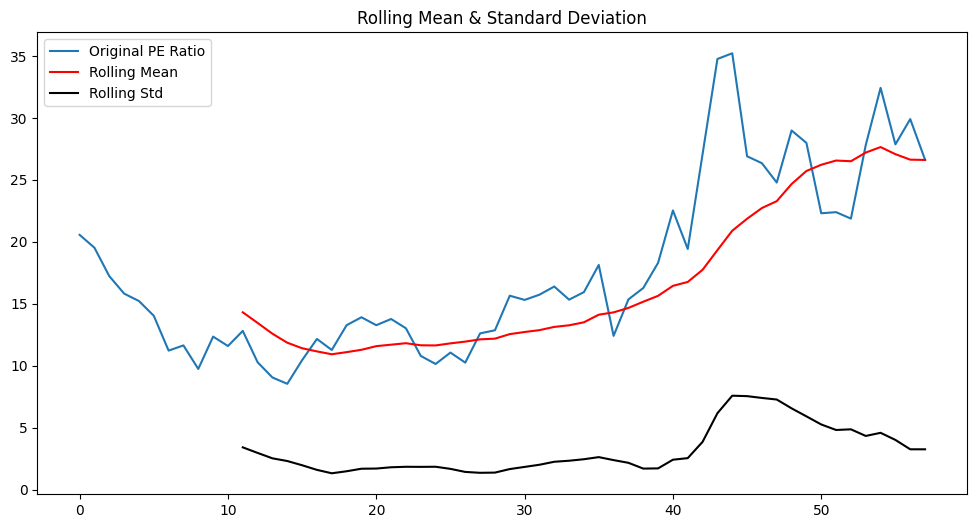

In [4]:
# EDA
# 1. Statistical Summary
df_summary = df.describe()
print(df_summary)

# 4. Rolling Statistics
rolling_window = 12

plt.figure(figsize=(12, 6))
rolling_mean = df['PE ratio'].rolling(window=rolling_window).mean()
rolling_std = df['PE ratio'].rolling(window=rolling_window).std()

plt.plot(df['PE ratio'], label='Original PE Ratio')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

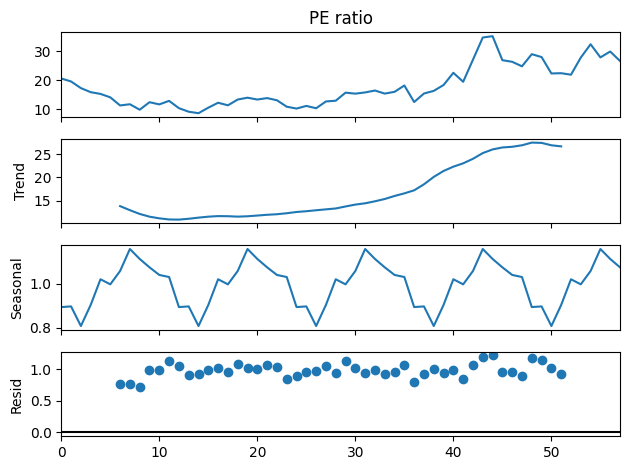

In [5]:
# 5. Decomposition of Time Series
result = seasonal_decompose(df['PE ratio'], model='multiplicative', period=12)
result.plot()
plt.show()

In [6]:
# Check for stationarity
result = adfuller(df['PE ratio'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')


ADF Statistic: -1.336379608120709
p-value: 0.6123686901469327
Critical Values 1%: -3.5506699942762414
Critical Values 5%: -2.913766394626147
Critical Values 10%: -2.5946240473991997


In [7]:
# Difference the series to make it stationary
df['PE ratio diff'] = df['PE ratio'].diff().dropna()
result = adfuller(df['PE ratio diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -3.7360075506366783
p-value: 0.0036342573948584507
Critical Values 1%: -3.568485864
Critical Values 5%: -2.92135992
Critical Values 10%: -2.5986616


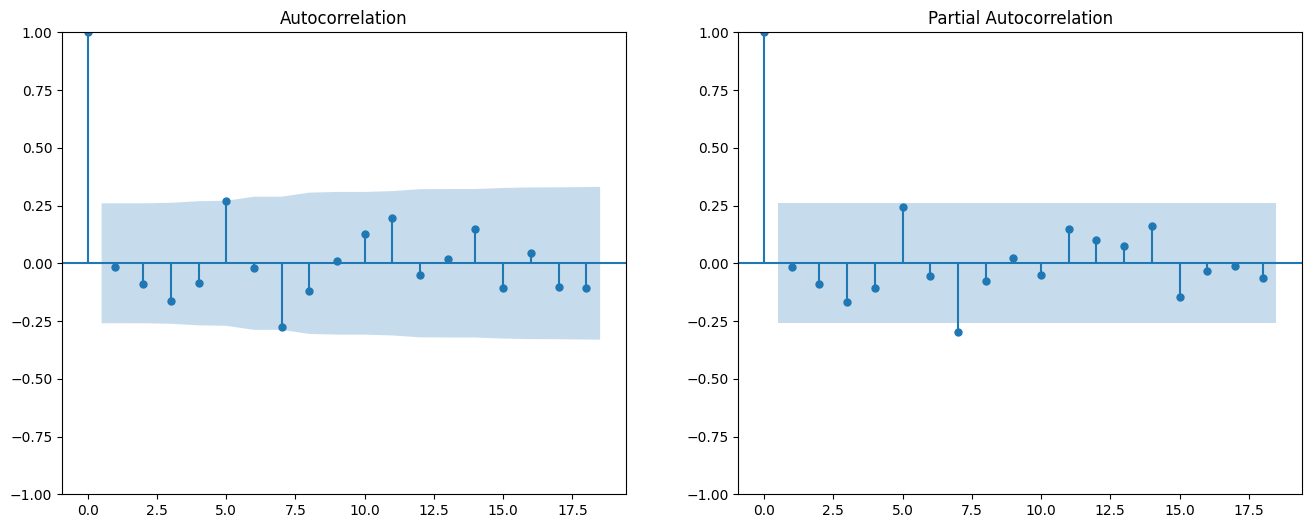

In [8]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['PE ratio diff'].dropna(), ax=axes[0])
plot_pacf(df['PE ratio diff'].dropna(), ax=axes[1])
plt.show()

In [9]:
# Train Test split
train_size = len(df) - 10
train, test = df[:train_size], df[train_size:]

In [10]:
# Fit ARIMA model using pmdarima for automatic selection
ARIMA_model = pm.auto_arima(train['PE ratio'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

ARIMA_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=230.685, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=232.637, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=232.632, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=228.737, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.505 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -113.369
Date:                Thu, 18 Jul 2024   AIC                            228.737
Time:                        14:44:08   BIC                            230.587
Sample:                             0   HQIC                           229.434
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.2886      1.007      7.241      0.000       5.316       9.261
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                11.90
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               5.95   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Best model ARIMA(0,1,0)

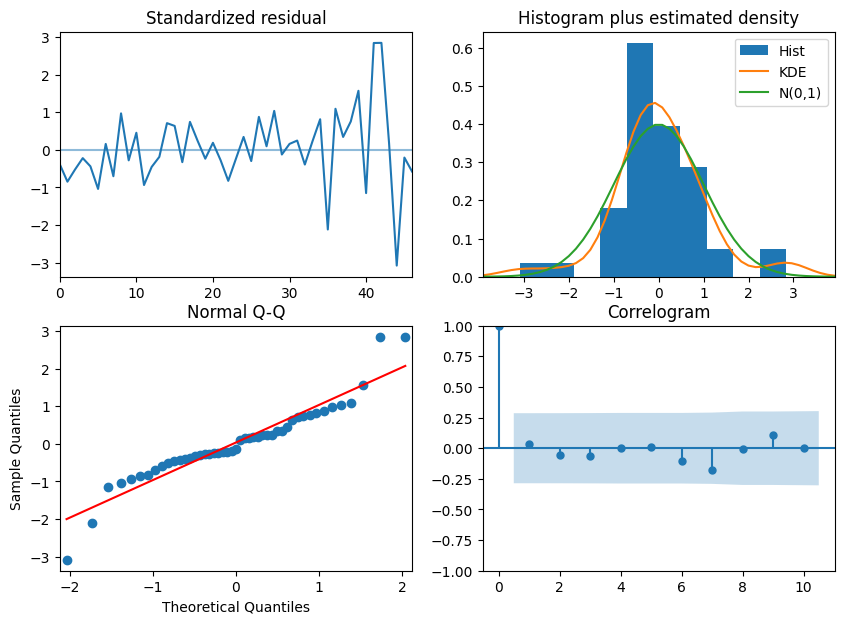

In [11]:
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

In [12]:
# Ljung-Box test
ARIMA_model = SARIMAX(train['PE ratio'], order=(0,1,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.015241,0.901747
2,0.445219,0.800427
3,0.771832,0.856192
4,0.817832,0.936042
5,0.892039,0.970795
6,1.822299,0.935295
7,2.184679,0.948916
8,2.402925,0.966104
9,3.189775,0.956293
10,3.234258,0.975361


### Residuals are observed values of iid RVs

In [13]:
# Predictions of last 10 months
ARIMA_pred = ARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

<ipython-input-13-5c1591380097>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


In [14]:
# Differencing the data seasonally
df_diff2 = np.diff(df['PE ratio'], n=4)
result = adfuller(df_diff2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -5.639645519526751
p-value: 1.043621230851394e-06
Critical Values 1%: -3.5812576580093696
Critical Values 5%: -2.9267849124681518
Critical Values 10%: -2.6015409829867675


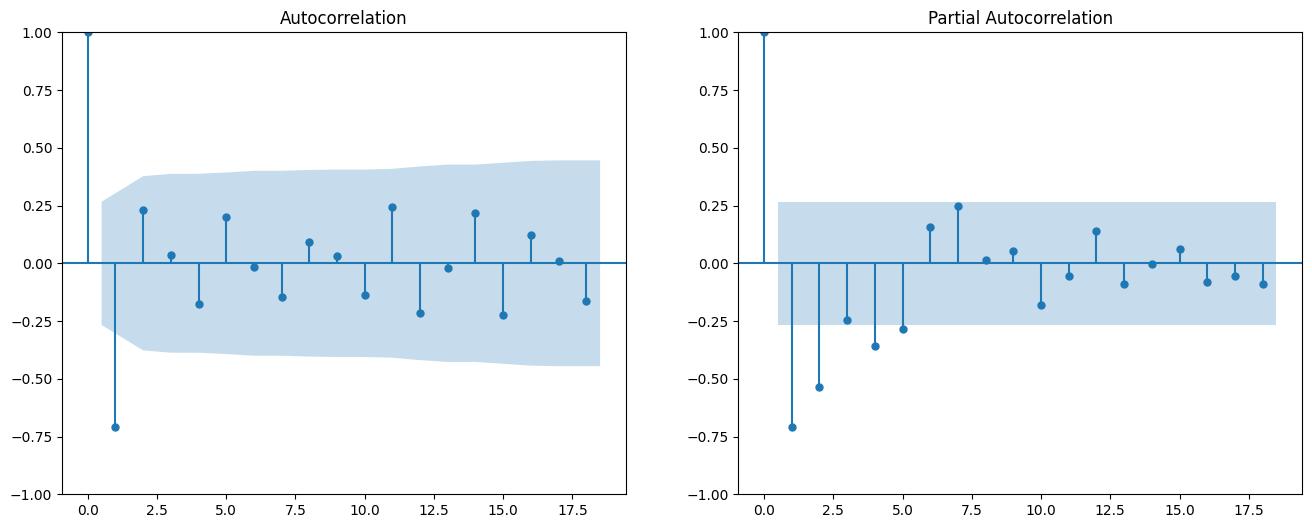

In [15]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(pd.DataFrame(df_diff2).dropna(), ax=axes[0])
plot_pacf(pd.DataFrame(df_diff2).dropna(), ax=axes[1])
plt.show()

In [16]:
SARIMA_model = pm.auto_arima(train["PE ratio"], start_p=1, start_q=1,
                         test='kpss',
                         max_p=5, max_q=5,
                         m=4, #12 is the frequncy of the cycle
                         start_P=1, start_Q=1,
                         max_P = 5, max_Q=5,
                         seasonal=True, #set to seasonal
                         d=1,
                         D=None,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
SARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=227.059, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=237.494, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=226.794, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=223.476, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=239.422, Time=0.16 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=225.070, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=225.048, Time=0.30 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=226.845, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=227.098, Time=0.99 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=221.567, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=223.135, Time=0.23 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=223.105, Time=0.32 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=225.070, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=225.189, Time=0.90 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=223.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 4)   Log Likelihood                -108.784
Date:                             Thu, 18 Jul 2024   AIC                            221.567
Time:                                     14:44:16   BIC                            225.090
Sample:                                          0   HQIC                           222.866
                                              - 48                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L4       -0.7927      0.152     -5.222      0.000      -1.090      -0.495
sigma2         8.4162      1.413      5.955      0.000       5.646      11.186
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.89
Prob(Q):                              0.95   Prob(JB):                         0.05
Heteroskedasticity (H):               5.75   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Best Model ARIMA(0,1,0)(0,1,1)[4]

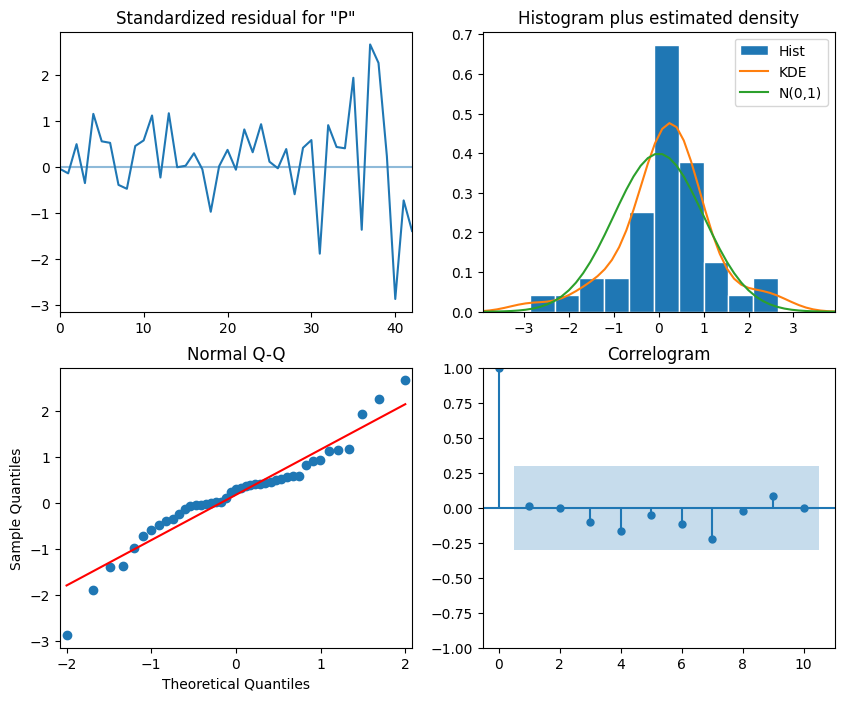

In [17]:
SARIMA_model = SARIMAX(train["PE ratio"], order=(0,1,0), seasonal_order=(0,1,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [18]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.007158,0.932577
2,0.010298,0.994864
3,0.331244,0.954049
4,5.068906,0.280300
5,5.374649,0.371887
6,5.823120,0.443293
7,6.210857,0.515356
8,6.304438,0.613171
9,7.343245,0.601430
10,7.372681,0.689855


### Residuals are observed values if IID RVs

In [19]:
# Predicting last 10 PEs of the data
SARIMA_pred = SARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

<ipython-input-19-dbe47345b5e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


In [20]:
# Fit GARCH model to the training set
garch_model = arch_model(train['PE ratio'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

In [21]:
# Forecast using the GARCH model
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_pred = garch_forecast.mean.iloc[-1].values
test['GARCH_pred'] = garch_pred

<ipython-input-21-a0d20fe8156c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GARCH_pred'] = garch_pred


In [22]:
# Fit ARMA model using pmdarima for automatic selection
arma_model = pm.auto_arima(train['PE ratio'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

arma_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=230.685, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=232.637, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=232.632, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=228.737, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.775 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -113.369
Date:                Thu, 18 Jul 2024   AIC                            228.737
Time:                        14:44:19   BIC                            230.587
Sample:                             0   HQIC                           229.434
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.2886      1.007      7.241      0.000       5.316       9.261
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                11.90
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               5.95   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# Get residuals from the ARMA model
residuals = arma_model.resid()

# Fit GARCH model to the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Forecast ARMA model
n_forecast = len(test)
arma_forecast, conf_int = arma_model.predict(n_periods=n_forecast, return_conf_int=True)

# Forecast GARCH model
garch_forecast = garch_fit.forecast(horizon=n_forecast)
garch_pred = garch_forecast.mean.iloc[-1].values

# Combine ARMA and GARCH forecasts
test['ARMA_GARCH_pred'] = arma_forecast + garch_pred

<ipython-input-23-e6f4f7f3b7e7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARMA_GARCH_pred'] = arma_forecast + garch_pred


In [24]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['PE ratio']])
test_scaled = scaler.transform(test[['PE ratio']])
test1 = df[-15:]
test1_scaled = scaler.transform(test1[['PE ratio']])

In [25]:
# Create the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 5
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)
X_test1, y_test1 = create_dataset(test1_scaled, time_step)

In [26]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_test = X_test.reshape(X_test.shape[0], time_step, 1)
X_test1 = X_test1.reshape(X_test1.shape[0], time_step, 1)

In [27]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
43/43 [==============================] - 11s 13ms/step - loss: 0.0631
Epoch 2/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0326
Epoch 3/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0307
Epoch 4/100
43/43 [==============================] - 1s 12ms/step - loss: 0.0384
Epoch 5/100
43/43 [==============================] - 1s 13ms/step - loss: 0.0259
Epoch 6/100
43/43 [==============================] - 0s 11ms/step - loss: 0.0272
Epoch 7/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0289
Epoch 8/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0257
Epoch 9/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0315
Epoch 10/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0249
Epoch 11/100
43/43 [==============================] - 0s 9ms/step - loss: 0.0237
Epoch 12/100
43/43 [==============================] - 0s 11ms/step - loss: 0.0255
Epoch 13/100
43/43 [======

In [28]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test1)
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

1/1 [==============================] - 0s 35ms/step


In [29]:
test['LSTM_pred'] = test_predict[:, 0]

<ipython-input-29-feca5b1a0150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM_pred'] = test_predict[:, 0]


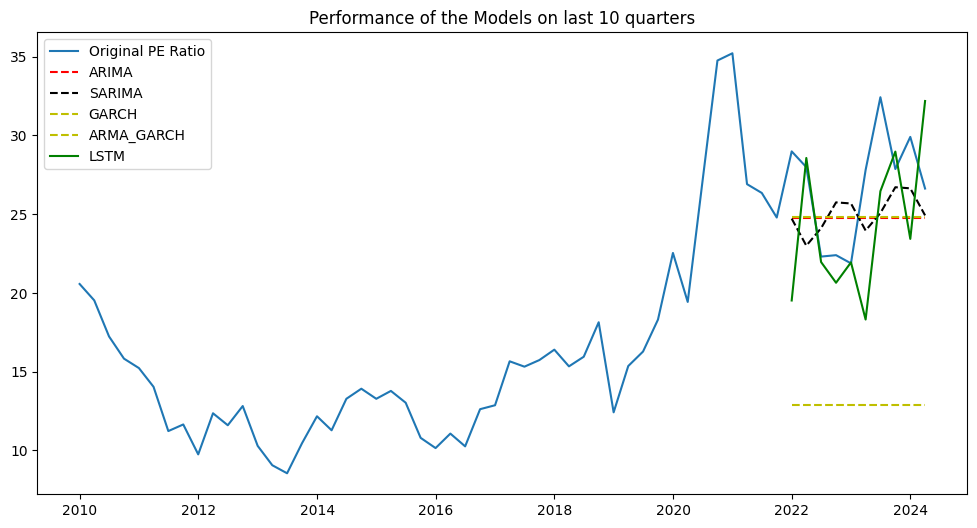

In [30]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'],df['PE ratio'], label='Original PE Ratio')
plt.plot(df['Date'][-10:], test['ARIMA_pred'], 'r--', label='ARIMA')
plt.plot(df['Date'][-10:], test['SARIMA_pred'],  'k--', label='SARIMA')
plt.plot(df['Date'][-10:], test['GARCH_pred'],  'y--', label='GARCH')
plt.plot(df['Date'][-10:], test['ARMA_GARCH_pred'],  'y--', label='ARMA_GARCH')
plt.plot(df['Date'][-10:], test['LSTM_pred'],  color = 'green', label='LSTM')
plt.title('Performance of the Models on last 10 quarters')
plt.legend()
plt.show()

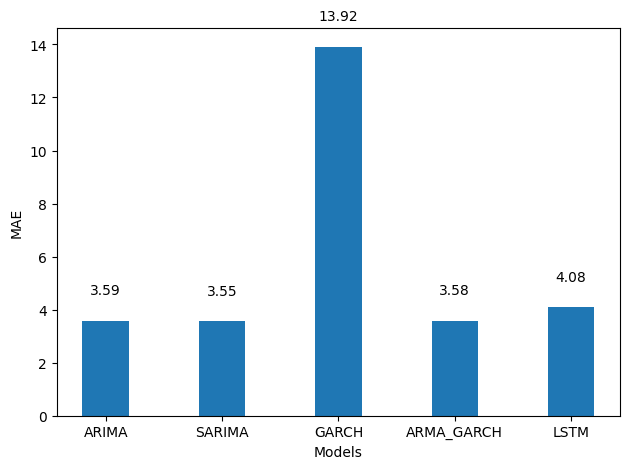

In [31]:
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)))

mae_ARIMA = mae(test['PE ratio'], test['ARIMA_pred'])
mae_SARIMA = mae(test['PE ratio'], test['SARIMA_pred'])
mae_GARCH = mae(test['PE ratio'], test['GARCH_pred'])
mae_ARMA_GARCH = mae(test['PE ratio'], test['ARMA_GARCH_pred'])
mae_LSTM = mae(test['PE ratio'], test['LSTM_pred'])

fig, ax = plt.subplots()

x = ['ARIMA', 'SARIMA', 'GARCH', 'ARMA_GARCH', 'LSTM']
y = [mae_ARIMA, mae_SARIMA, mae_GARCH, mae_ARMA_GARCH, mae_LSTM]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()

1/1 [==============================] - 0s 21ms/step
Forecasted PE Ratios for the next 20 quarters:
[19.521633  17.402466  15.247118  11.503533   7.8897514  6.934525
  7.1944766  8.241404   9.504565  10.827956  11.99766   12.859926
 13.399977  13.696982  13.848651  13.917588  13.937977  13.931367
 13.911409  13.886125 ]


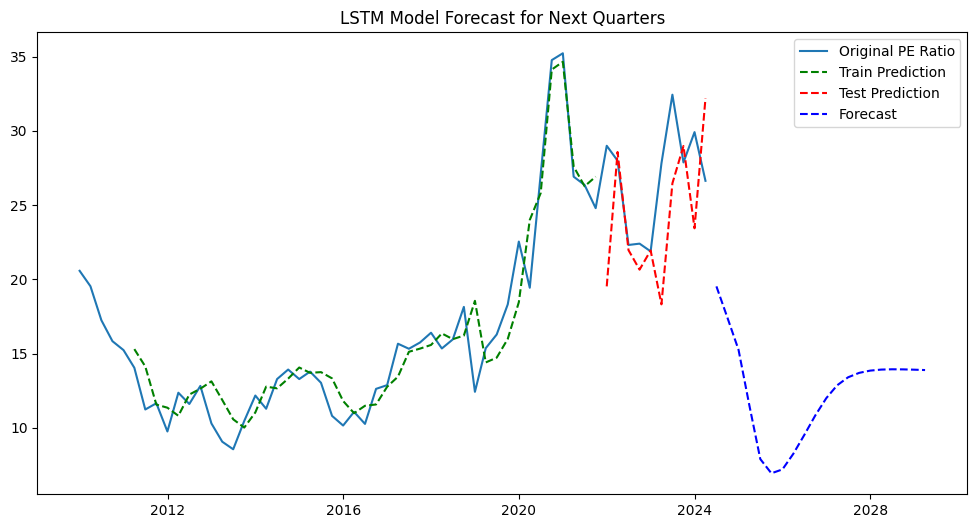

In [32]:
# Forecasting the next n_steps quarters
n_steps = 20 # Number of steps to forecast
last_time_steps = train_scaled[-time_step:]  # Use the last time_step values from training set

forecasts = []
for i in range(n_steps):
    next_pred = model.predict(last_time_steps.reshape(1, time_step, 1))
    forecasts.append(next_pred[0, 0])
    last_time_steps = np.roll(last_time_steps, -1)
    last_time_steps[-1] = next_pred

# Invert forecasts to original scale
forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Print and plot forecasts
print("Forecasted PE Ratios for the next", n_steps, "quarters:")
print(forecasts.flatten())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['PE ratio'], label='Original PE Ratio')
plt.plot(df['Date'][time_step:train_size], train_predict, 'g--', label='Train Prediction')
plt.plot(df['Date'][-10:], test_predict, 'r--', label='Test Prediction')
plt.plot(pd.date_range(df['Date'].iloc[-1], periods=n_steps+1, freq='Q')[1:], forecasts, 'b--', label='Forecast')
plt.title('LSTM Model Forecast for Next Quarters')
plt.legend()
plt.show()

# ROE

In [35]:
url = 'https://www.macrotrends.net/stocks/charts/AAPL/apple/roe'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

response = requests.get(url, headers=headers)
response.raise_for_status()  # Ensure we notice bad responses
data = pd.read_html(response.text, skiprows=1)
df = pd.DataFrame(data[0])
df = pd.concat([df.columns.to_frame().T, df], ignore_index=True)
df.columns = range(len(df.columns))
df = df[1:]
df = df.rename(columns={0 : 'Date', 1 : 'TTMNI', 2 : 'SE', 3 : 'ROE'})
df.set_index('Date', inplace = True)
df['ROE'] = df['ROE'].str.replace('%', '').astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index().reset_index()
l = len(df['ROE'])
df.head(5)

,Date,TTMNI,SE,ROE
0,2009-12-31,$9.36B,$35.77B,31.83
1,2010-03-31,$10.81B,$39.35B,32.60
2,2010-06-30,$12.24B,$43.11B,32.66
3,2010-09-30,$14.01B,$47.79B,33.76
4,2010-12-31,$16.64B,$54.67B,35.99


                                Date         ROE
count                             58   58.000000
mean   2017-02-13 11:35:10.344827648   66.688793
min              2009-12-31 00:00:00   28.930000
25%              2013-07-23 00:00:00   35.690000
50%              2017-02-14 00:00:00   41.800000
75%              2020-09-07 00:00:00   74.027500
max              2024-03-31 00:00:00  165.720000
std                              NaN   47.585917


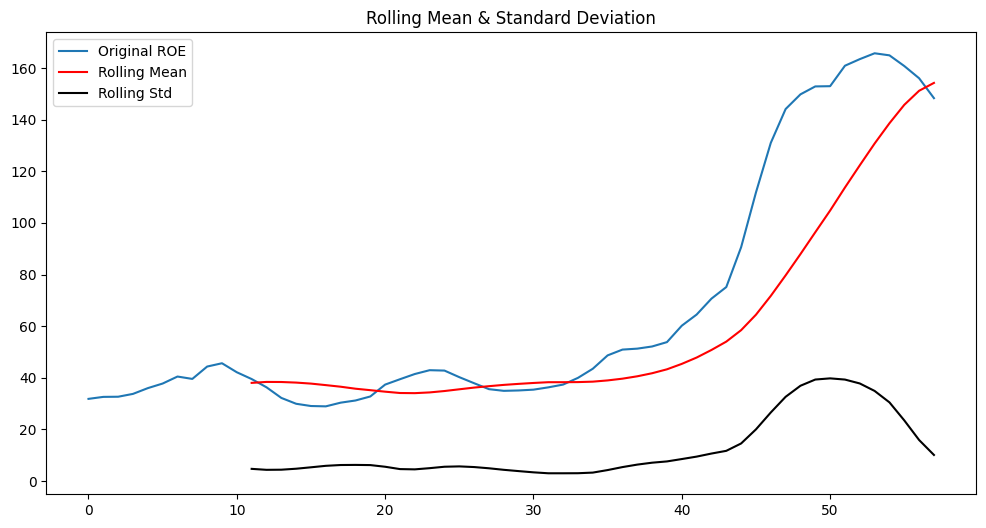

In [36]:
# EDA

# 1. Statistical Summary
df_summary = df.describe()
print(df_summary)

# 4. Rolling Statistics
rolling_window = 12

plt.figure(figsize=(12, 6))
rolling_mean = df['ROE'].rolling(window=rolling_window).mean()
rolling_std = df['ROE'].rolling(window=rolling_window).std()

plt.plot(df['ROE'], label='Original ROE')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

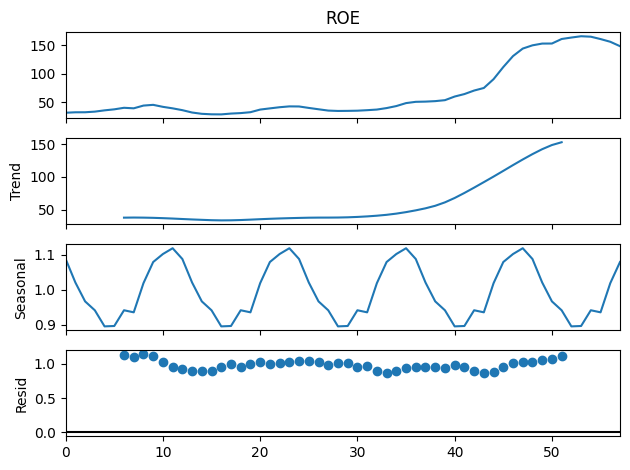

In [37]:
# 5. Decomposition of Time Series
result = seasonal_decompose(df['ROE'], model='multiplicative', period=12)
result.plot()
plt.show()

In [38]:
# Check for stationarity
result = adfuller(df['ROE'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -2.2559104337980083
p-value: 0.18658206183850884
Critical Values 1%: -3.5812576580093696
Critical Values 5%: -2.9267849124681518
Critical Values 10%: -2.6015409829867675


In [39]:
# Difference the series to make it stationary
df['ROE diff'] = df['ROE'].diff().dropna()
result = adfuller(df['ROE diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -2.1977641042106155
p-value: 0.20705795868825477
Critical Values 1%: -3.5778480370438146
Critical Values 5%: -2.925338105429433
Critical Values 10%: -2.6007735310095064


In [40]:
# Difference the series to make it stationary
df['ROE diff'] = df['ROE diff'].diff().dropna()
result = adfuller(df['ROE diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -1.9950574300628057
p-value: 0.28874444008703687
Critical Values 1%: -3.5778480370438146
Critical Values 5%: -2.925338105429433
Critical Values 10%: -2.6007735310095064


In [41]:
# Difference the series to make it stationary
df['ROE diff'] = df['ROE diff'].diff().dropna()
result = adfuller(df['ROE diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -4.496573660432236
p-value: 0.0001994621810922749
Critical Values 1%: -3.5778480370438146
Critical Values 5%: -2.925338105429433
Critical Values 10%: -2.6007735310095064


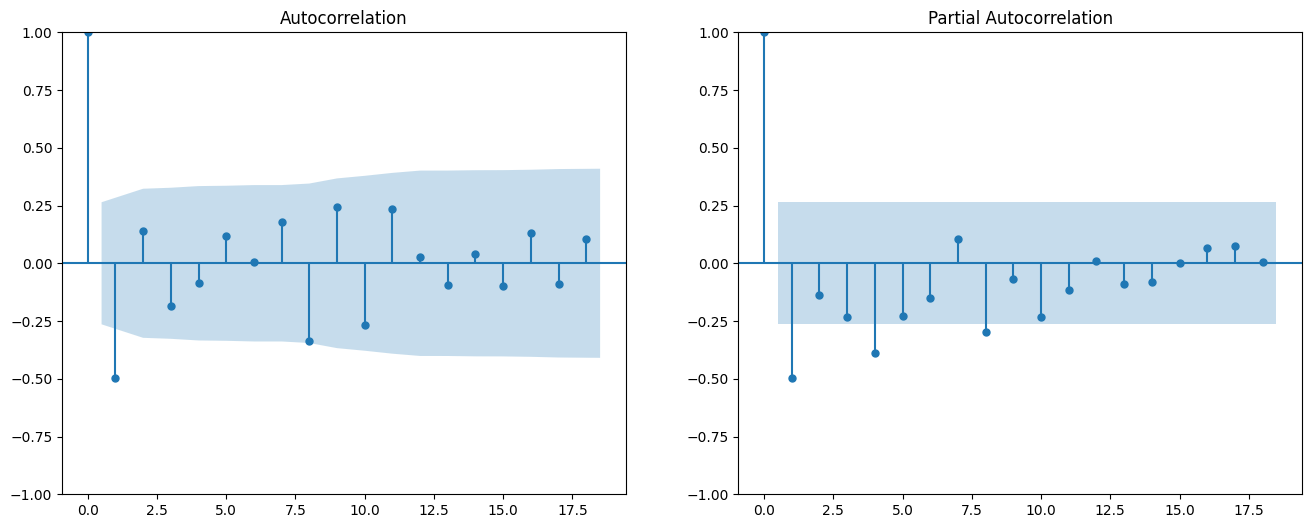

In [42]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['ROE diff'].dropna(), ax=axes[0])
plot_pacf(df['ROE diff'].dropna(), ax=axes[1])
plt.show()

In [43]:
# Train Test split
train_size = len(df) - 10
train, test = df[:train_size], df[train_size:]

In [44]:
# Fit ARIMA model using pmdarima for automatic selection
ARIMA_model = pm.auto_arima(train['ROE'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

ARIMA_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=229.997, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=231.996, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=231.996, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=228.411, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=233.961, Time=0.16 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.372 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -113.206
Date:                Thu, 18 Jul 2024   AIC                            228.411
Time:                        14:47:19   BIC                            230.240
Sample:                             0   HQIC                           229.096
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.0373      1.002      8.024      0.000       6.074      10.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.48
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.65   Skew:                             1.01
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Best Model ARIMA(0, 2, 0)

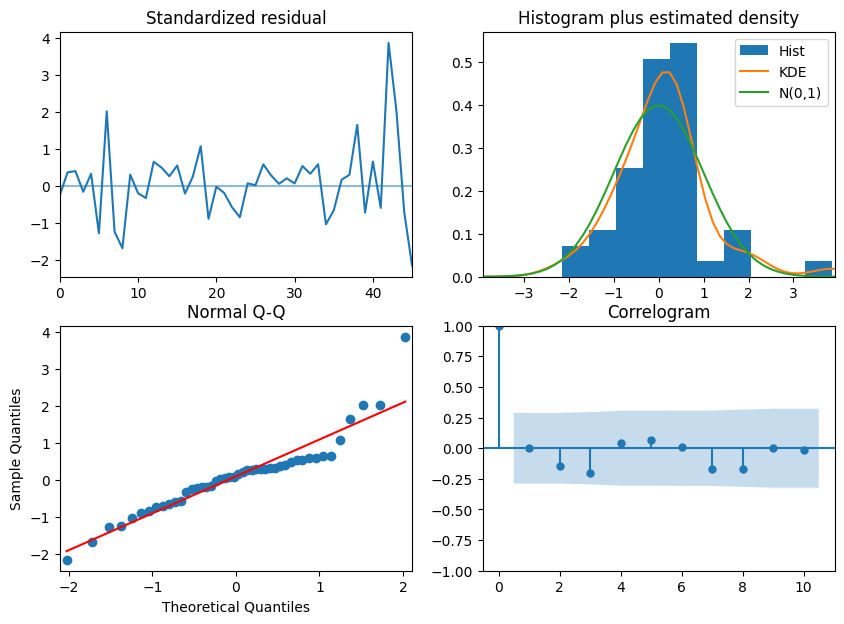

In [45]:
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

In [46]:
# Ljung-Box test
ARIMA_model = SARIMAX(train['ROE'], order=(0,2,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,4.376160,0.036445
2,4.572705,0.101637
3,4.657913,0.198630
4,4.726958,0.316477
5,4.728131,0.449952
6,4.897178,0.557067
7,6.537659,0.478549
8,7.210454,0.514106
9,7.242611,0.611876
10,7.984021,0.630398


### Observed residuals are from IID distribution

In [47]:
# Predictions of last 10 months
ARIMA_pred = ARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

<ipython-input-47-5c1591380097>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


In [48]:
# Differencing the data seasonally
df_diff2 = np.diff(df['ROE'], n=4)
result = adfuller(df_diff2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -4.49257285668369
p-value: 0.00020280640374708374
Critical Values 1%: -3.5925042342183704
Critical Values 5%: -2.931549768951162
Critical Values 10%: -2.60406594375338


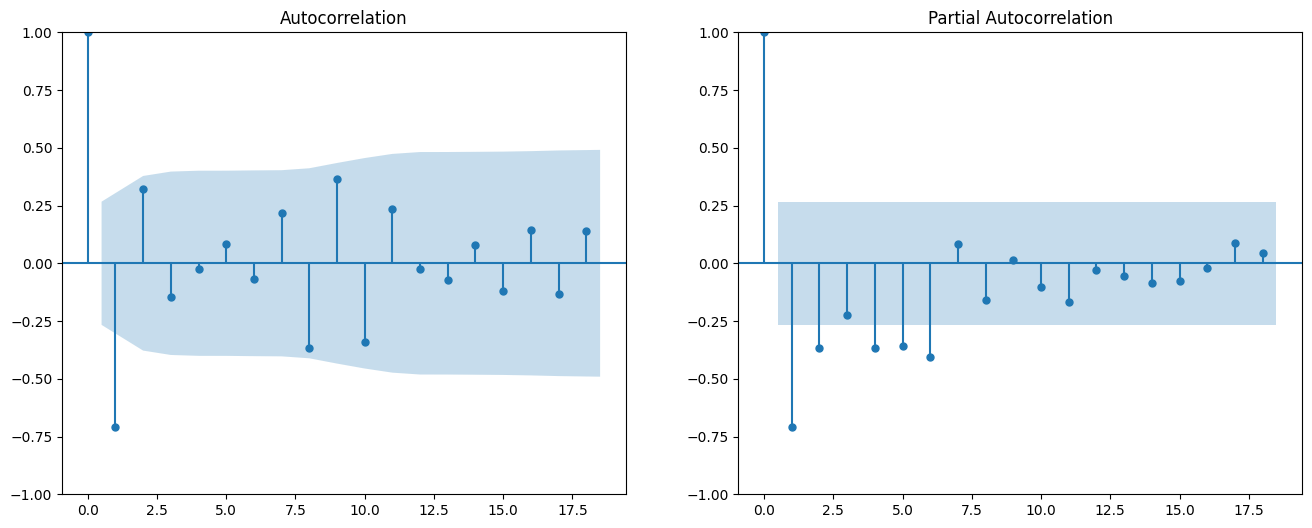

In [49]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(pd.DataFrame(df_diff2).dropna(), ax=axes[0])
plot_pacf(pd.DataFrame(df_diff2).dropna(), ax=axes[1])
plt.show()

In [50]:
SARIMA_model = pm.auto_arima(train["ROE"], start_p=1, start_q=1,
                         test='kpss',
                         max_p=5, max_q=5,
                         m=4, #12 is the frequncy of the cycle
                         start_P=1, start_Q=1,
                         max_P = 5, max_Q=5,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=None,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
SARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[4]             : AIC=232.641, Time=0.60 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=228.411, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=232.217, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=231.947, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=230.225, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=229.948, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=230.048, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=230.394, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[4]             : AIC=230.388, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=232.344, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=229.997, Time=0.03 sec

Best model:  ARIMA(0,2,0)(0,0,0)[4]          
Total fit time: 1.379 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -113.206
Date:                Thu, 18 Jul 2024   AIC                            228.411
Time:                        14:47:25   BIC                            230.240
Sample:                             0   HQIC                           229.096
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.0373      1.002      8.024      0.000       6.074      10.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.48
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.65   Skew:                             1.01
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best Model ARIMA(0, 2, 0)(0, 0, 0)[4]

This Model is the same as ARIMA(0, 2, 0)

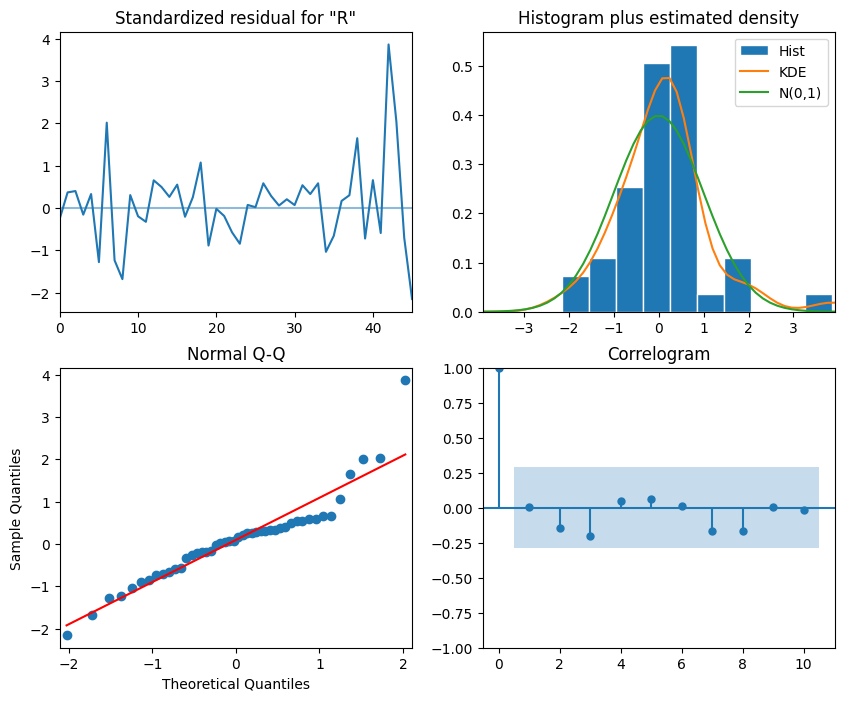

In [51]:
SARIMA_model = SARIMAX(train["ROE"], order=(0,2,0), seasonal_order=(0,0,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [52]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,4.376160,0.036445
2,4.572705,0.101637
3,4.657913,0.198630
4,4.726958,0.316477
5,4.728131,0.449952
6,4.897178,0.557067
7,6.537659,0.478549
8,7.210454,0.514106
9,7.242611,0.611876
10,7.984021,0.630398


In [53]:
# Predicting last 10 PEs of the data
SARIMA_pred = SARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

<ipython-input-53-dbe47345b5e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


In [54]:
# Fit GARCH model to the training set
garch_model = arch_model(train['ROE'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

In [55]:
# Forecast using the GARCH model
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_pred = garch_forecast.mean.iloc[-1].values
test['GARCH_pred'] = garch_pred

<ipython-input-55-a0d20fe8156c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GARCH_pred'] = garch_pred


In [56]:
# Fit ARMA model using pmdarima for automatic selection
arma_model = pm.auto_arima(train['ROE'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

arma_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=229.997, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=231.996, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=231.996, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=228.411, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=233.961, Time=0.19 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.421 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -113.206
Date:                Thu, 18 Jul 2024   AIC                            228.411
Time:                        14:47:27   BIC                            230.240
Sample:                             0   HQIC                           229.096
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.0373      1.002      8.024      0.000       6.074      10.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.48
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.65   Skew:                             1.01
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
# Get residuals from the ARMA model
residuals = arma_model.resid()

# Fit GARCH model to the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Forecast ARMA model
n_forecast = len(test)
arma_forecast, conf_int = arma_model.predict(n_periods=n_forecast, return_conf_int=True)

# Forecast GARCH model
garch_forecast = garch_fit.forecast(horizon=n_forecast)
garch_pred = garch_forecast.mean.iloc[-1].values

# Combine ARMA and GARCH forecasts
test['ARMA_GARCH_pred'] = arma_forecast + garch_pred

<ipython-input-57-e6f4f7f3b7e7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARMA_GARCH_pred'] = arma_forecast + garch_pred


In [58]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['ROE']])
test_scaled = scaler.transform(test[['ROE']])
test1 = df[-15:]
test1_scaled = scaler.transform(test1[['ROE']])

In [59]:
# Create the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 5
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)
X_test1, y_test1 = create_dataset(test1_scaled, time_step)

In [60]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_test = X_test.reshape(X_test.shape[0], time_step, 1)
X_test1 = X_test1.reshape(X_test1.shape[0], time_step, 1)

In [61]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
43/43 [==============================] - 8s 5ms/step - loss: 0.0554
Epoch 2/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0294
Epoch 3/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 4/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 5/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 6/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0100
Epoch 7/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 8/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 9/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 10/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 11/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 12/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 13/100
43/43 [=================

In [62]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test1)
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

1/1 [==============================] - 0s 22ms/step


In [63]:
test['LSTM_pred'] = test_predict[:, 0]

<ipython-input-63-feca5b1a0150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM_pred'] = test_predict[:, 0]


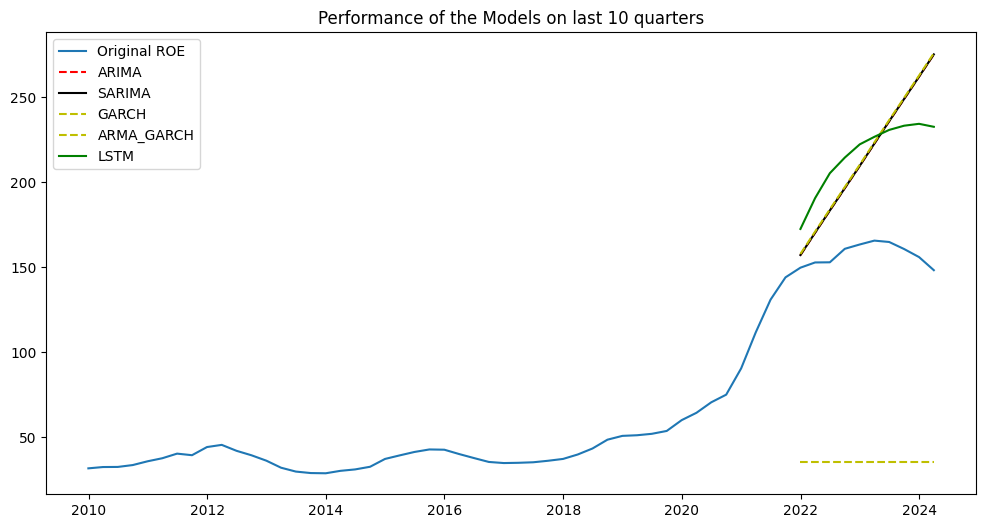

In [64]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'],df['ROE'], label='Original ROE')
plt.plot(df['Date'][-10:], test['ARIMA_pred'], 'r--', label='ARIMA')
plt.plot(df['Date'][-10:], test['SARIMA_pred'],  color = 'black', label='SARIMA')
plt.plot(df['Date'][-10:], test['GARCH_pred'],  'y--', label='GARCH')
plt.plot(df['Date'][-10:], test['ARMA_GARCH_pred'],  'y--', label='ARMA_GARCH')
plt.plot(df['Date'][-10:], test['LSTM_pred'],  color = 'green', label='LSTM')
plt.title('Performance of the Models on last 10 quarters')
plt.legend()
plt.show()

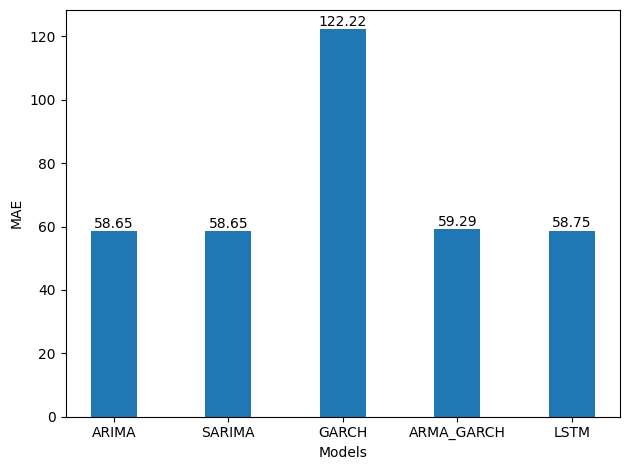

In [65]:
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)))

mae_ARIMA = mae(test['ROE'], test['ARIMA_pred'])
mae_SARIMA = mae(test['ROE'], test['SARIMA_pred'])
mae_GARCH = mae(test['ROE'], test['GARCH_pred'])
mae_ARMA_GARCH = mae(test['ROE'], test['ARMA_GARCH_pred'])
mae_LSTM = mae(test['ROE'], test['LSTM_pred'])

fig, ax = plt.subplots()

x = ['ARIMA', 'SARIMA', 'GARCH', 'ARMA_GARCH', 'LSTM']
y = [mae_ARIMA, mae_SARIMA, mae_GARCH, mae_ARMA_GARCH, mae_LSTM]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()

1/1 [==============================] - 0s 27ms/step
Forecasted PE Ratios for the next 20 quarters:
[172.57327 199.57707 226.46748 253.41017 278.60037 302.55154 322.35376
 338.2154  350.6061  359.98798 366.94974 371.94922 375.51437 378.04272
 379.82266 381.06848 381.9352  382.53827 382.95752 383.24847]


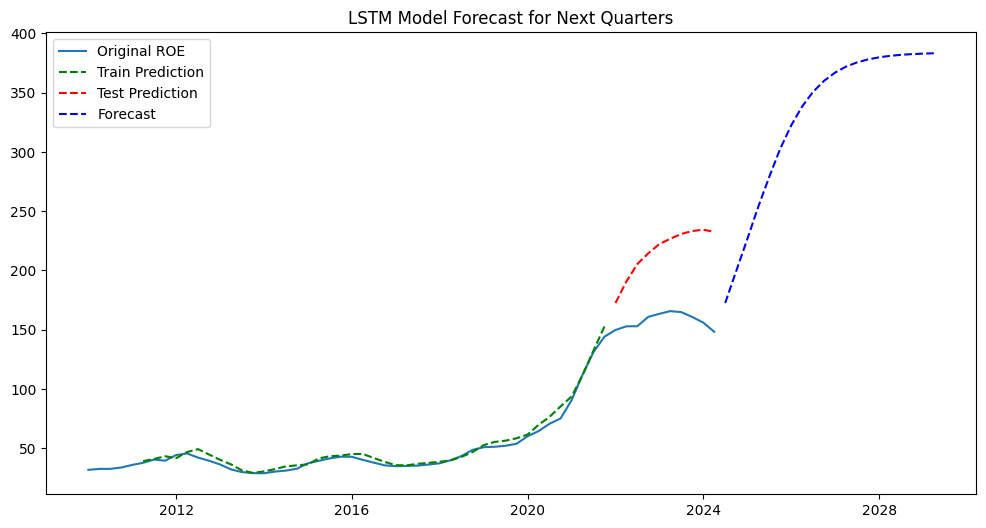

In [66]:
# Forecasting the next n_steps quarters
n_steps = 20 # Number of steps to forecast
last_time_steps = train_scaled[-time_step:]  # Use the last time_step values from training set

forecasts = []
for i in range(n_steps):
    next_pred = model.predict(last_time_steps.reshape(1, time_step, 1))
    forecasts.append(next_pred[0, 0])
    last_time_steps = np.roll(last_time_steps, -1)
    last_time_steps[-1] = next_pred

# Invert forecasts to original scale
forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Print and plot forecasts
print("Forecasted PE Ratios for the next", n_steps, "quarters:")
print(forecasts.flatten())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['ROE'], label='Original ROE')
plt.plot(df['Date'][time_step:train_size], train_predict, 'g--', label='Train Prediction')
plt.plot(df['Date'][-10:], test_predict, 'r--', label='Test Prediction')
plt.plot(pd.date_range(df['Date'].iloc[-1], periods=n_steps+1, freq='Q')[1:], forecasts, 'b--', label='Forecast')
plt.title('LSTM Model Forecast for Next Quarters')
plt.legend()
plt.show()